In [1]:
# install dependencies
%pip install -q \
  matplotlib \
  optuna \
  pandas \
  pycaret \
  "pycaret[analysis]" \
  seaborn

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
# set up the environment for the notebook
import os
os.environ['PYCARET_CUSTOM_LOGGING_LEVEL'] = 'CRITICAL'

import pandas
pandas.set_option('display.max_columns', 128)

In [3]:
# prepare the data
from pathlib import Path
from pycaret.datasets import get_data
from zipfile import ZipFile

data_name = 'heart_2022_no_nans'

# extract the compressed data file
if Path(f'../data/{data_name}.csv').exists():
  print(f'Data file "{data_name}" was already extracted')
else:
  ZipFile(f'../data/{data_name}.zip', 'r').extract(
    f'data/{data_name}.csv', '..'
  )
  print(f'Data file "{data_name}" has been extracted successfully')

# load the data
print(f'Loading data file "{data_name}"')
DATA = get_data(dataset=f'../data/{data_name}')

Data file "heart_2022_no_nans" was already extracted
Loading data file "heart_2022_no_nans"


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 65 to 69,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 70 to 74,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,No,No,No,No,No,No,No,Yes,No,No,Yes,No,Yes,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 75 to 79,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,Yes,No,Yes,No,Yes,No,No,No,No,Yes,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [4]:
# setting column specifications
TARGET_NAME = 'HadHeartAttack'
IDENTIFIERS = ['State']

In [5]:
# establish an experiment
from pycaret.classification import ClassificationExperiment

exp = ClassificationExperiment()
exp.setup(
  data=DATA,
  train_size=0.5,
  target=TARGET_NAME,
  ignore_features=IDENTIFIERS,
  index=True,
  session_id=123,
  remove_multicollinearity=True,
  multicollinearity_threshold=0.999,
  imputation_type=None,
  fold_shuffle=True,
  max_encoding_ohe=16,
  # group_features={
  #   'Group_Sickness': [
  #     'HadHeartAttack',
  #     'HadAngina',
  #     'HadStroke',    
  #     'HadAsthma',
  #     'HadSkinCancer',
  #     'HadCOPD',
  #     'HadDepressiveDisorder',
  #     'HadKidneyDisease',
  #     'HadArthritis',  
  #     'HadDiabetes',
  #     'RemovedTeeth',
  #   ],
  #   'Group_Difficulty': [
  #     'DeafOrHardOfHearing',
  #     'BlindOrVisionDifficulty',   
  #     'DifficultyConcentrating',
  #     'DifficultyWalking',
  #     'DifficultyDressingBathing',
  #     'DifficultyErrands',
  #   ],
  #   'Group_Behavior': [
  #     'SmokerStatus',
  #     'ECigaretteUsage',
  #     'AlcoholDrinkers',
  #   ],
  #   'Group_Vax': [
  #     'FluVaxLast12',
  #     'PneumoVaxEver',
  #     'TetanusLast10Tdap',
  #     'CovidPos',
  #   ],
  #   'Group_Health': [
  #     'GeneralHealth',
  #     'PhysicalHealthDays',
  #     'MentalHealthDays',
  #     'LastCheckupTime',
  #     'PhysicalActivities',
  #   ],
  # },
)
exp.dataset_transformed.head(5)

,Description,Value
0,Session id,123
1,Target,HadHeartAttack
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(246022, 40)"
5,Transformed data shape,"(246022, 79)"
6,Transformed train set shape,"(123011, 79)"
7,Transformed test set shape,"(123011, 79)"
8,Ignore features,1
9,Ordinal features,22


,Sex,GeneralHealth_Good,GeneralHealth_Fair,GeneralHealth_Very good,GeneralHealth_Excellent,GeneralHealth_Poor,PhysicalHealthDays,MentalHealthDays,LastCheckupTime_Within past year (anytime less than 12 months ago),LastCheckupTime_5 or more years ago,LastCheckupTime_Within past 5 years (2 years but less than 5 years ago),LastCheckupTime_Within past 2 years (1 year but less than 2 years ago),PhysicalActivities,SleepHours,RemovedTeeth_1 to 5,RemovedTeeth_None of them,"RemovedTeeth_6 or more, but not all",RemovedTeeth_All,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes_No,HadDiabetes_Yes,"HadDiabetes_No, pre-diabetes or borderline diabetes","HadDiabetes_Yes, but only during pregnancy (female)",DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus_Never smoked,SmokerStatus_Current smoker - now smokes every day,SmokerStatus_Current smoker - now smokes some days,SmokerStatus_Former smoker,ECigaretteUsage_Never used e-cigarettes in my entire life,ECigaretteUsage_Not at all (right now),ECigaretteUsage_Use them some days,ECigaretteUsage_Use them every day,ChestScan,"RaceEthnicityCategory_White only, Non-Hispanic","RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic",AgeCategory_Age 75 to 79,AgeCategory_Age 65 to 69,AgeCategory_Age 70 to 74,AgeCategory_Age 60 to 64,AgeCategory_Age 35 to 39,AgeCategory_Age 25 to 29,AgeCategory_Age 40 to 44,AgeCategory_Age 18 to 24,AgeCategory_Age 30 to 34,AgeCategory_Age 80 or older,AgeCategory_Age 50 to 54,AgeCategory_Age 45 to 49,AgeCategory_Age 55 to 59,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,"TetanusLast10Tdap_Yes, received Tdap","TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years","TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap","TetanusLast10Tdap_Yes, received tetanus shot but not sure what type",HighRiskLastYear,CovidPos_No,CovidPos_Yes,CovidPos_Tested positive using home test without a health professional,HadHeartAttack
127101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.63,90.720001,34.330002,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
216411,0.0,0.0,1.0,0.0,0.0,0.0,30.0,15.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.63,56.700001,21.459999,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
12994,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.65,67.129997,24.629999,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
228959,0.0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.65,117.930000,43.270000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
218280,1.0,0.0,0.0,0.0,1.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.75,68.040001,22.150000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0


In [6]:
print('Removed columns: ',
  set(IDENTIFIERS) |
  (
    set(exp.dataset.columns) -
    set(exp.dataset_transformed.columns)
  )
)

Removed columns:  {'AgeCategory', 'SmokerStatus', 'HadDiabetes', 'LastCheckupTime', 'RaceEthnicityCategory', 'RemovedTeeth', 'GeneralHealth', 'TetanusLast10Tdap', 'State', 'ECigaretteUsage', 'CovidPos'}


In [7]:
# set global plot parameters
import matplotlib.pyplot as plt
import seaborn as sns

# reset old global plot parameters
plt.rcdefaults()

# adjustable global plot parameters
COLORMAP = sns.color_palette()
DPI = 400
OUTLINE_WIDTH = 0.2
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.linewidth'] = OUTLINE_WIDTH
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['font.size'] = 4
plt.rcParams['xtick.major.width'] = OUTLINE_WIDTH
plt.rcParams['xtick.minor.width'] = OUTLINE_WIDTH
plt.rcParams['ytick.major.width'] = OUTLINE_WIDTH
plt.rcParams['ytick.minor.width'] = OUTLINE_WIDTH

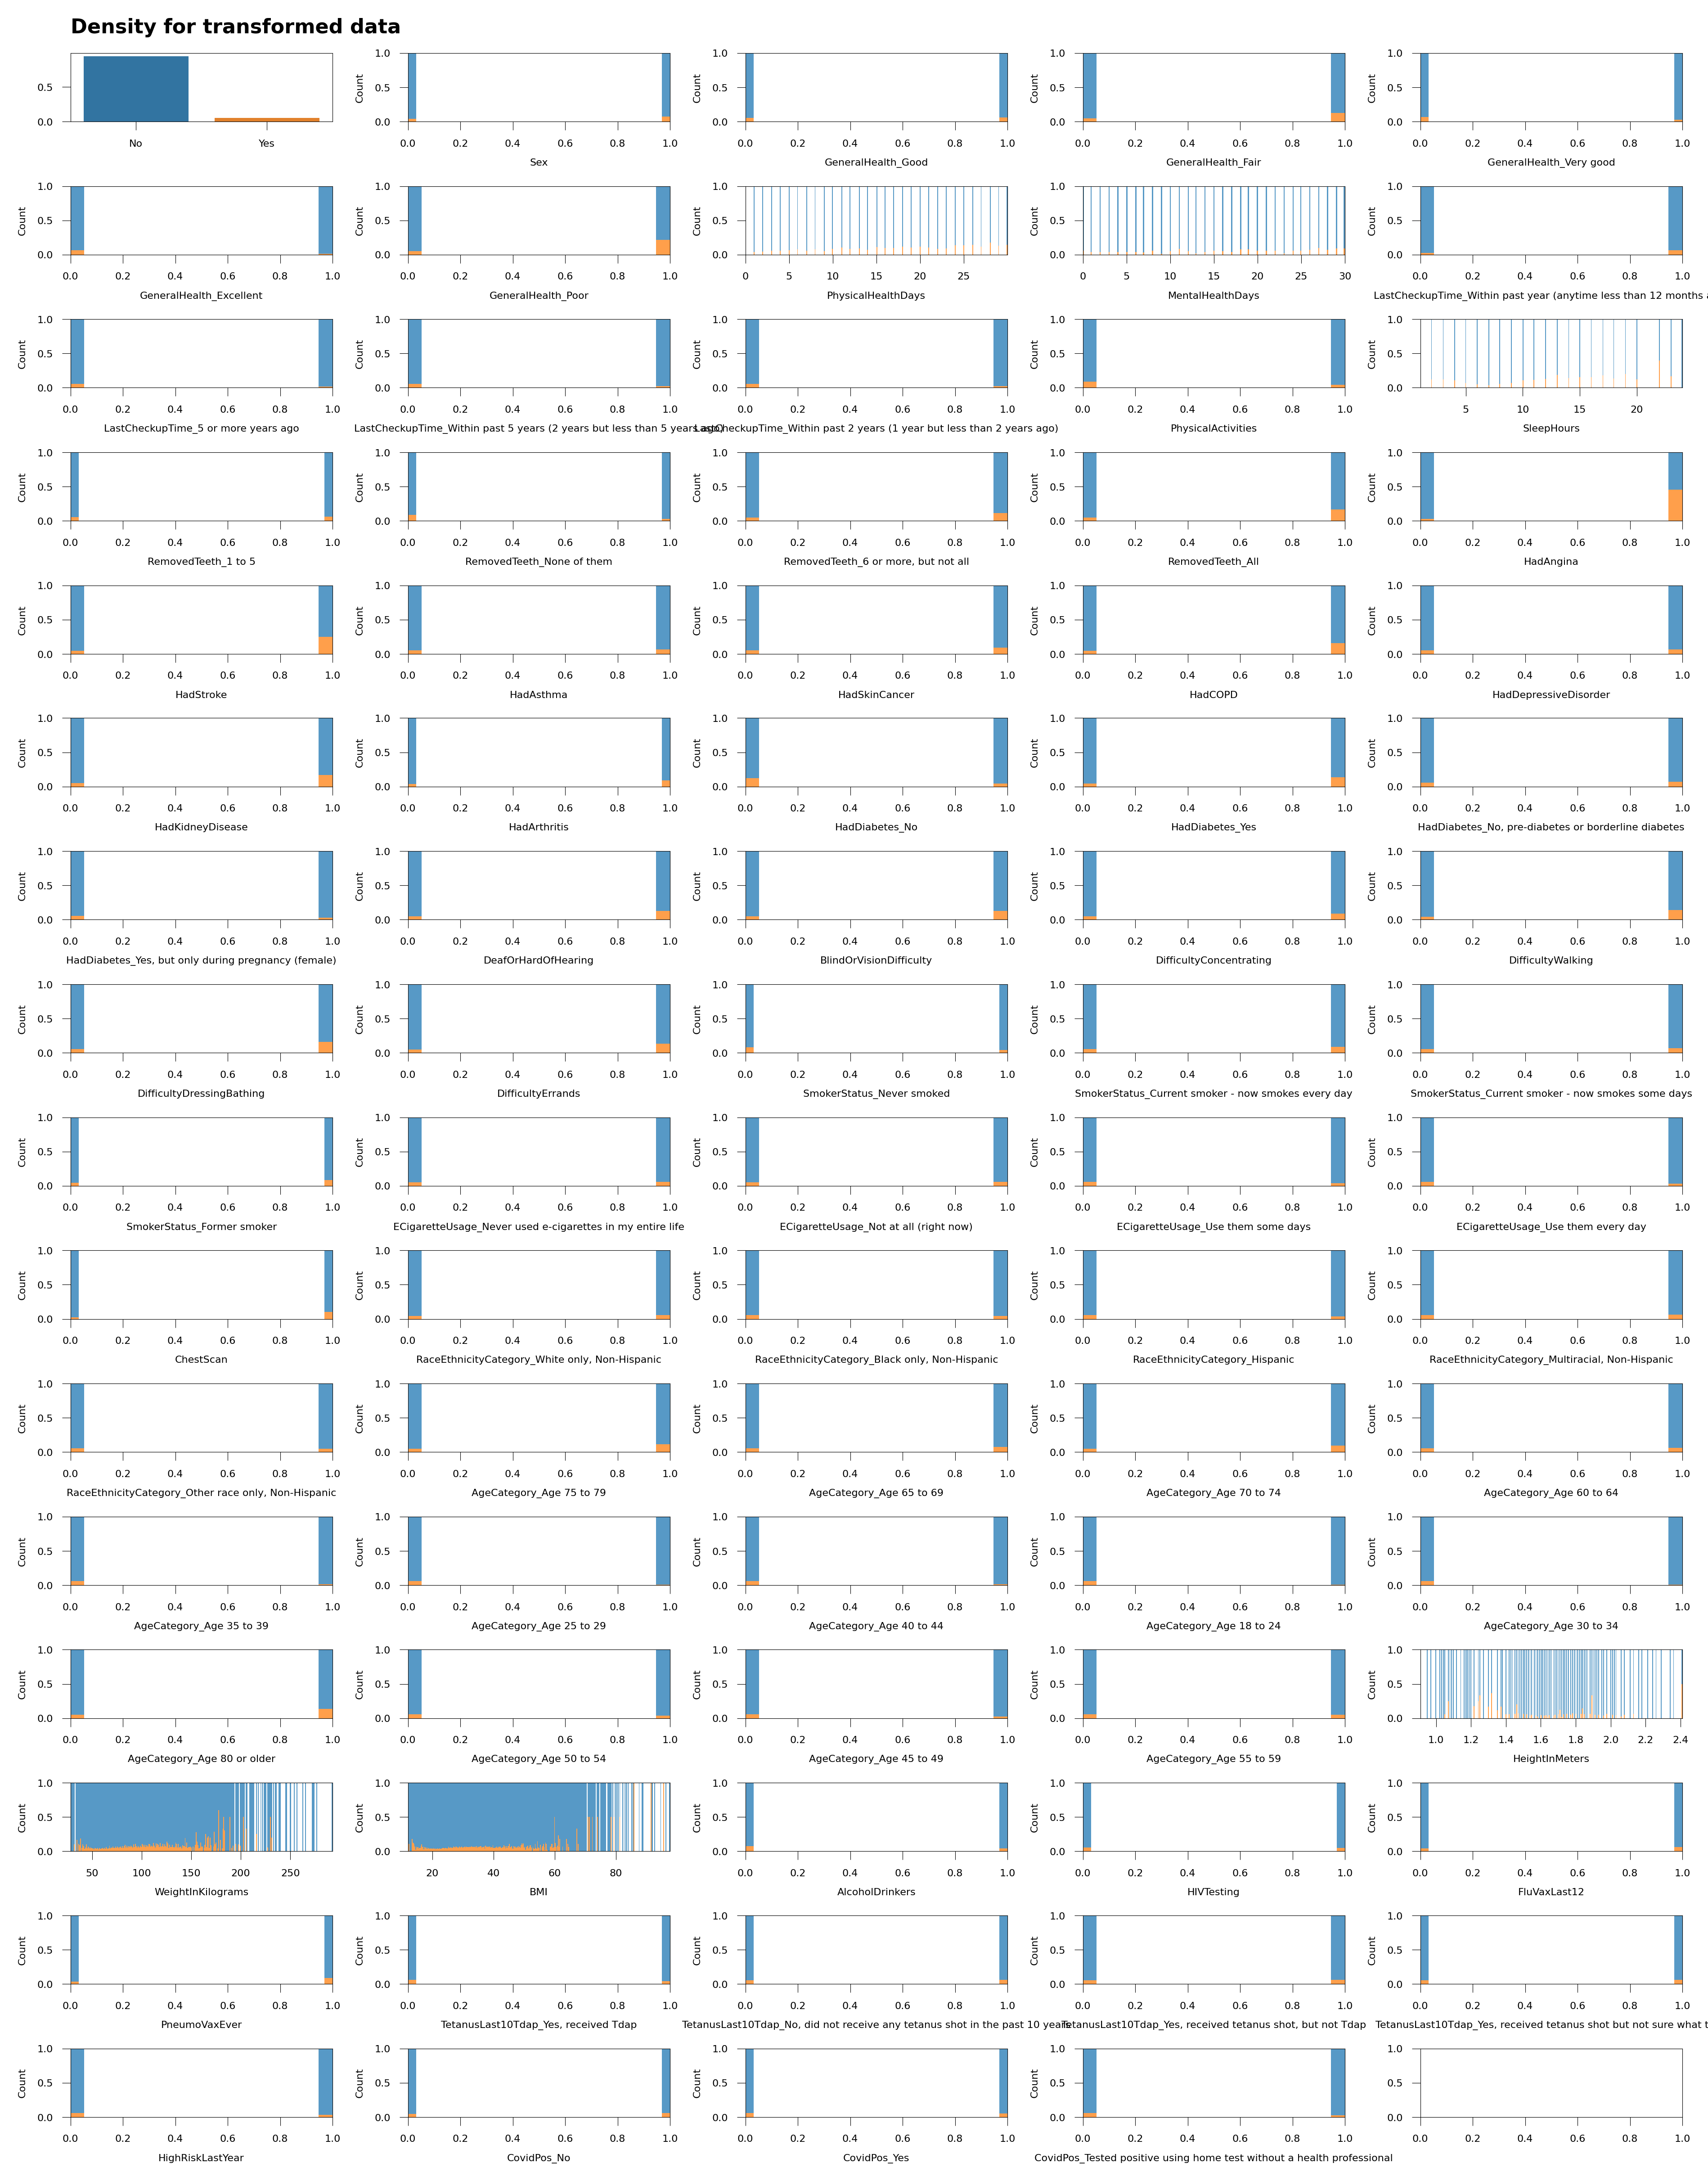

In [9]:
# show the distributions of the data
from math import ceil

# adjustable local plot parameters
TITLE = 'Density for transformed data'
SUBPLOT_SIZE = (750, 300)

# setting local plot parameters
plots_per_col = 5
shape = (plots_per_col, ceil(exp.dataset_transformed.shape[1] / plots_per_col))
figsize = tuple(pxs[0] * pxs[1] / DPI for pxs in zip(SUBPLOT_SIZE, shape))
title_params = {
  'fontdict': {
    'fontsize': plt.rcParams['font.size'] * 2,
    'fontweight': 'bold',
  },
  'loc': 'left',
  'pad': plt.rcParams['font.size'] * 2,
}
title_params['label'] = TITLE

# plot grid
axs = plt.subplots(
  nrows=shape[1],
  ncols=shape[0],
  layout='constrained',
  figsize=figsize,
)[1].flat

# plot target distribution
target_dist_data = exp.y.value_counts(normalize=True)
ax = sns.barplot(
  x=target_dist_data.index,
  y=target_dist_data.values,
  ax=axs[0],
  palette=COLORMAP,
)

# plot data title
axs[0].set_title(**title_params)

# plot features distribution
for x, ax in zip(exp.X_transformed.columns, axs[1:]):
  sns.histplot(
    data=exp.dataset_transformed,
    x=x,
    ax=ax,
    hue=TARGET_NAME,
    legend=False,
    linewidth=0,
    multiple='fill',
    palette=COLORMAP,
  )

# save the plot
plt.savefig(
  fname=f'../images/{TITLE}.png',
  bbox_inches='tight',
)

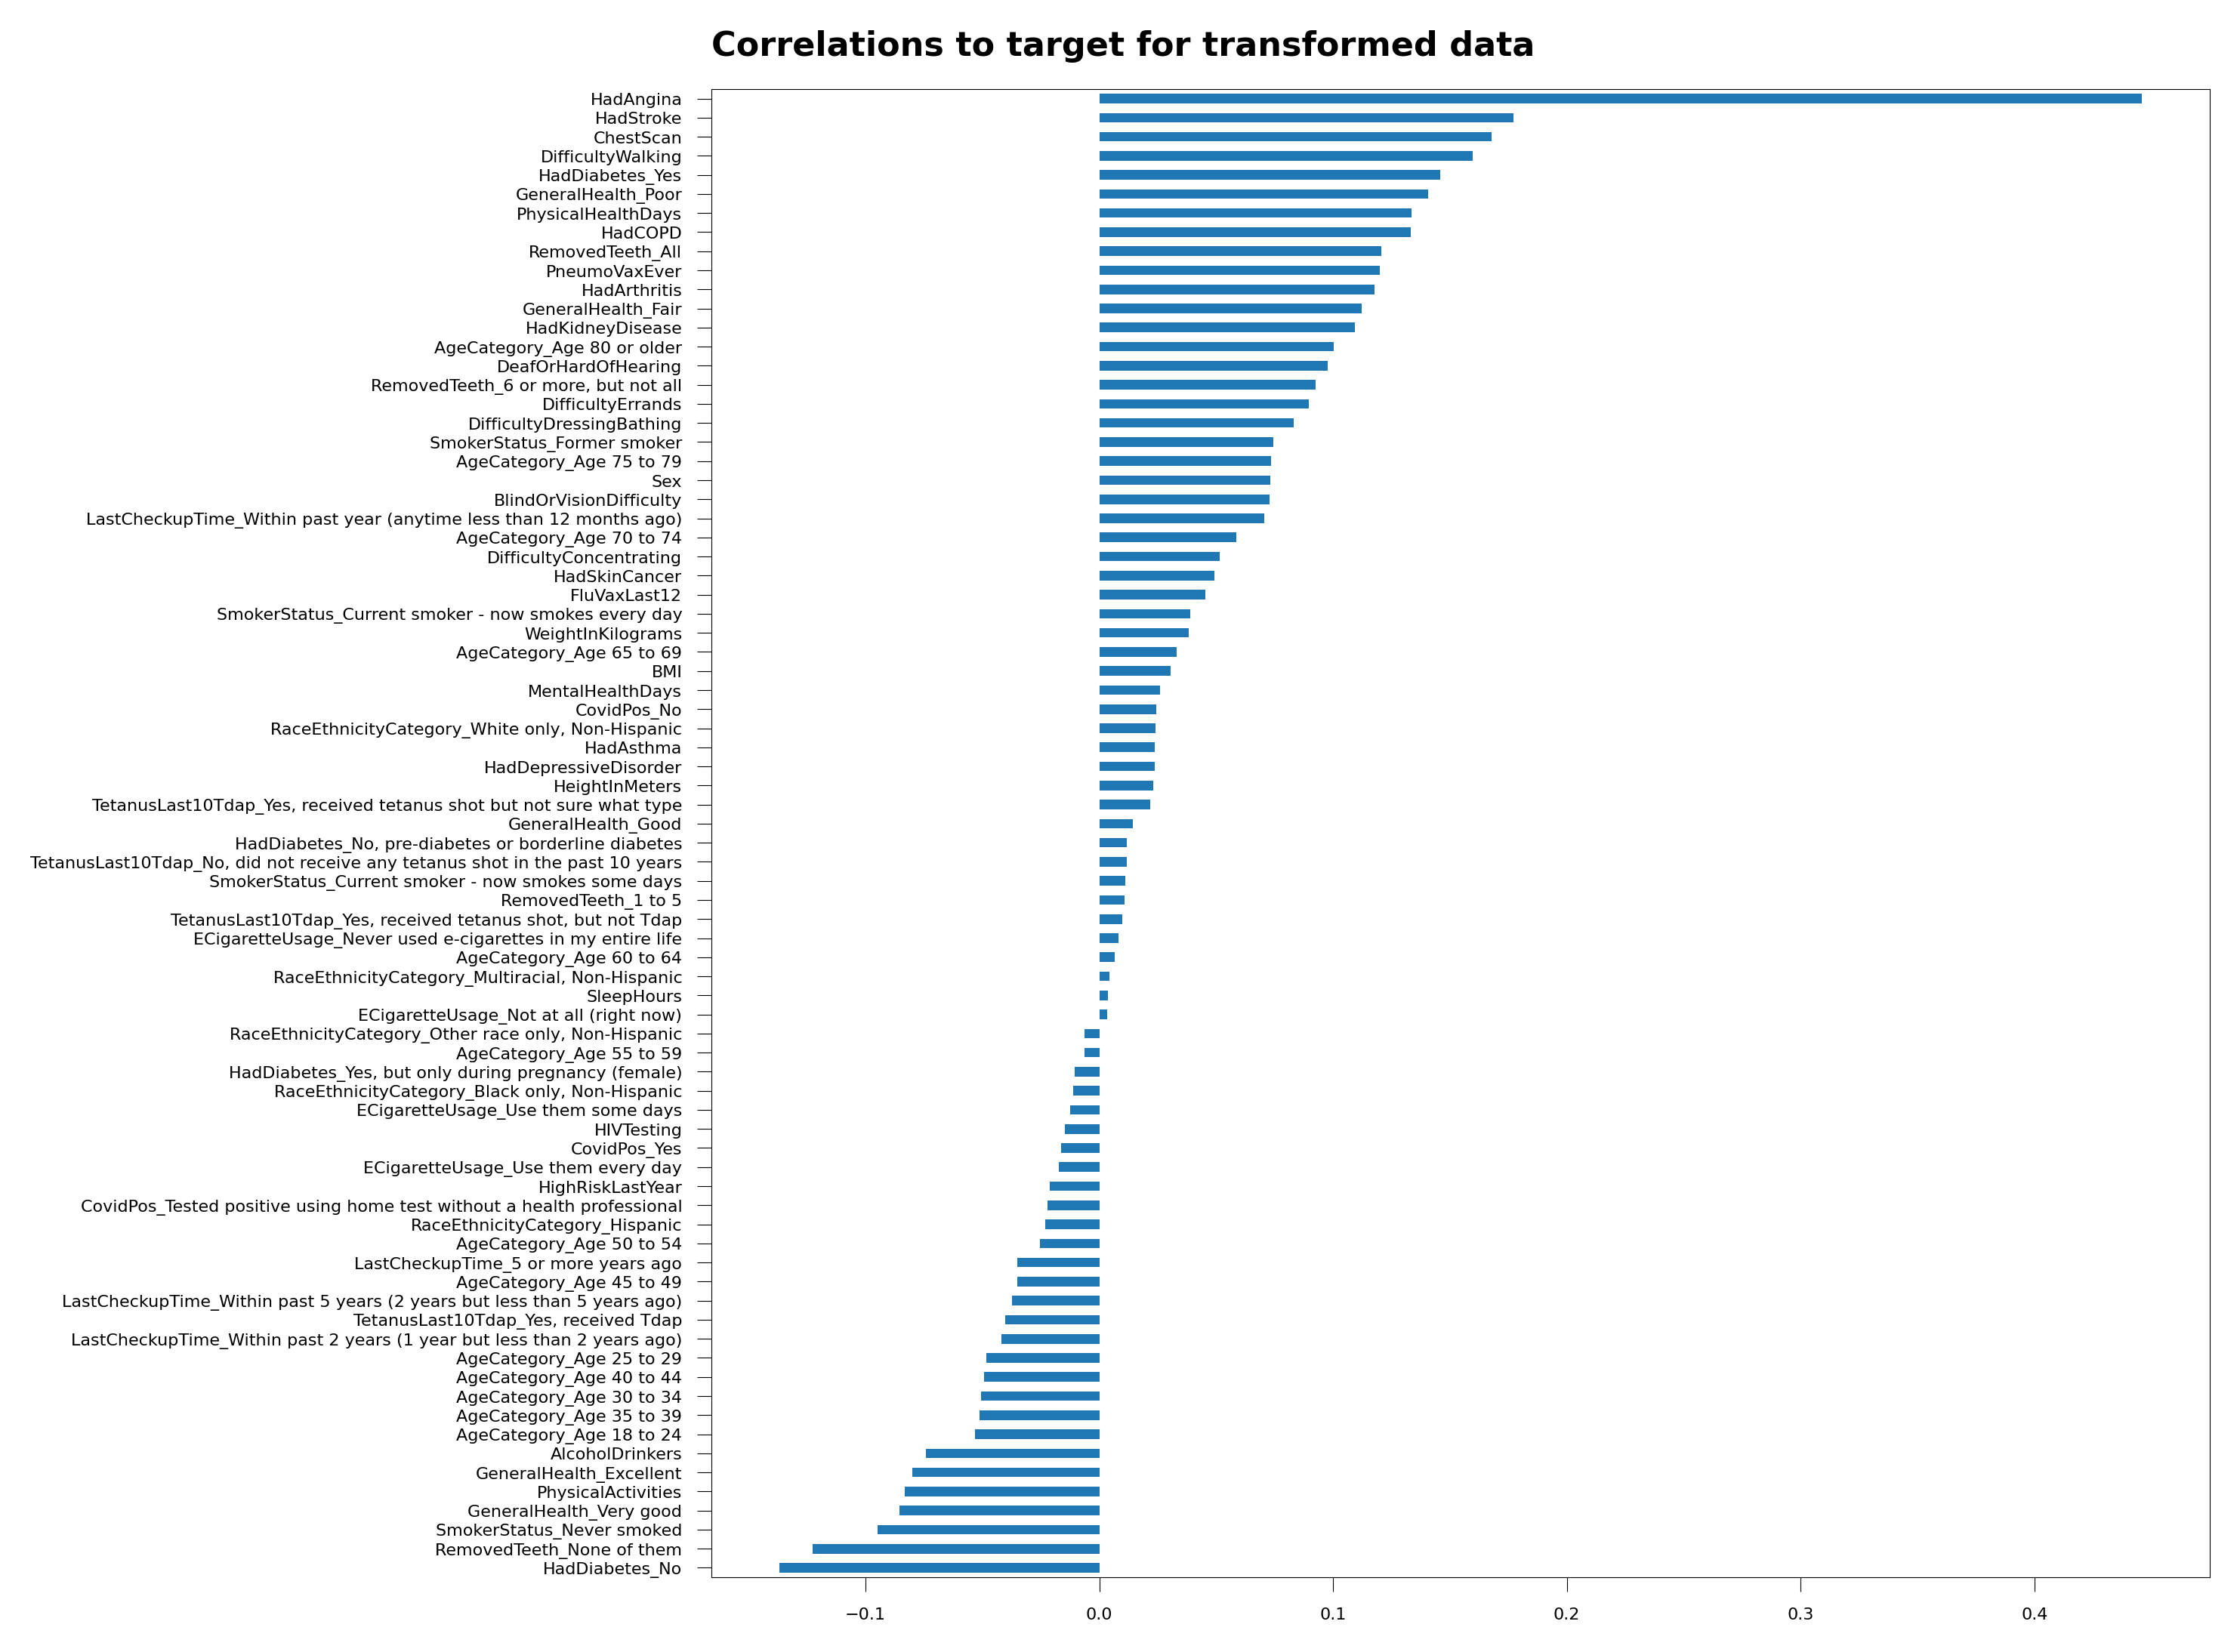

In [10]:
# check correlation between target and features
# adjustable plot parameters
TITLE = 'Correlations to target for transformed data'
PLOT_SIZE = (2560, 2560)

# setting plot parameters
figsize = tuple(px / DPI for px in PLOT_SIZE)
title_params['label'] = TITLE

# plot correlation to target
target_corr_data = (exp.dataset_transformed
  .corr()[TARGET_NAME]
  .drop(TARGET_NAME)
  .sort_values())
ax = target_corr_data.plot.barh(figsize=figsize)
ax.set_title(**title_params)

# save the plot
plt.savefig(
  fname=f'../images/{TITLE}.png',
  bbox_inches='tight',
)

In [11]:
# compare models with AUROC
exp.compare_models(
  exclude=[ # excludes slow and unsuitable models
    'catboost',
    'knn',
    'ridge',
    'svm',
  ],
  sort='auc',
)
None

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9488,0.8920,0.9488,0.9369,0.9392,0.3253,0.3555,3.0830
lr,Logistic Regression,0.9487,0.8903,0.9487,0.9369,0.9392,0.3268,0.3563,2.1780
ada,Ada Boost Classifier,0.9480,0.8903,0.9480,0.9366,0.9395,0.3379,0.3612,1.1930
lda,Linear Discriminant Analysis,0.9401,0.8870,0.9401,0.9433,0.9416,0.4495,0.4503,0.7530
xgboost,Extreme Gradient Boosting,0.9476,0.8816,0.9476,0.9353,0.9382,0.3168,0.3441,0.7980
rf,Random Forest Classifier,0.9476,0.8747,0.9476,0.9324,0.9307,0.1856,0.2528,2.3180
et,Extra Trees Classifier,0.9477,0.8699,0.9477,0.9329,0.9336,0.2350,0.2869,2.5190
nb,Naive Bayes,0.7319,0.8478,0.7319,0.9402,0.8047,0.1742,0.2707,0.6600
qda,Quadratic Discriminant Analysis,0.5197,0.8163,0.5197,0.9382,0.6251,0.0799,0.1719,0.6940
dt,Decision Tree Classifier,0.9150,0.6263,0.9150,0.9211,0.9180,0.2348,0.2356,0.8290


In [12]:
# # if the ranking not shown, uncomment and run this cell
# exp.pull()

In [15]:
# assign the best model id manually

best_model = exp.create_model(estimator='gbc')
best_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9496,0.8986,0.9496,0.9381,0.9399,0.3323,0.3650
1,0.9489,0.8894,0.9489,0.9369,0.9390,0.3197,0.3523
2,0.9488,0.8977,0.9488,0.9371,0.9395,0.3305,0.3591
3,0.9510,0.8948,0.9510,0.9410,0.9427,0.3717,0.3990
4,0.9481,0.8877,0.9481,0.9356,0.9382,0.3138,0.3439
5,0.9487,0.8919,0.9487,0.9374,0.9400,0.3401,0.3659
6,0.9460,0.8949,0.9460,0.9316,0.9350,0.2723,0.3034
7,0.9481,0.8909,0.9481,0.9356,0.9382,0.3138,0.3439
8,0.9482,0.8882,0.9482,0.9367,0.9394,0.3350,0.3601


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

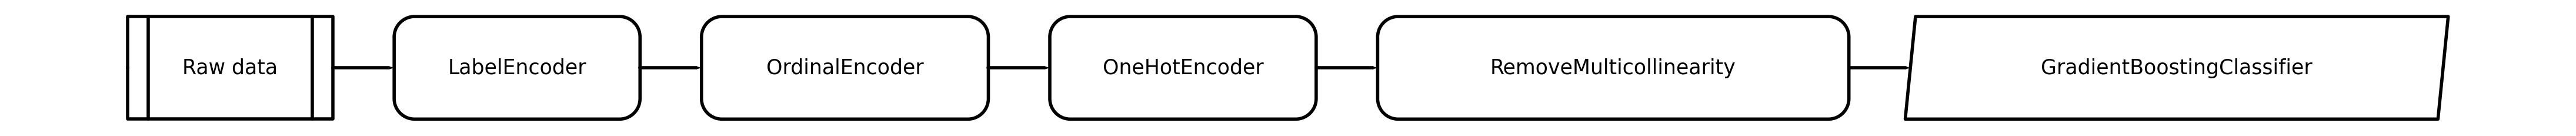

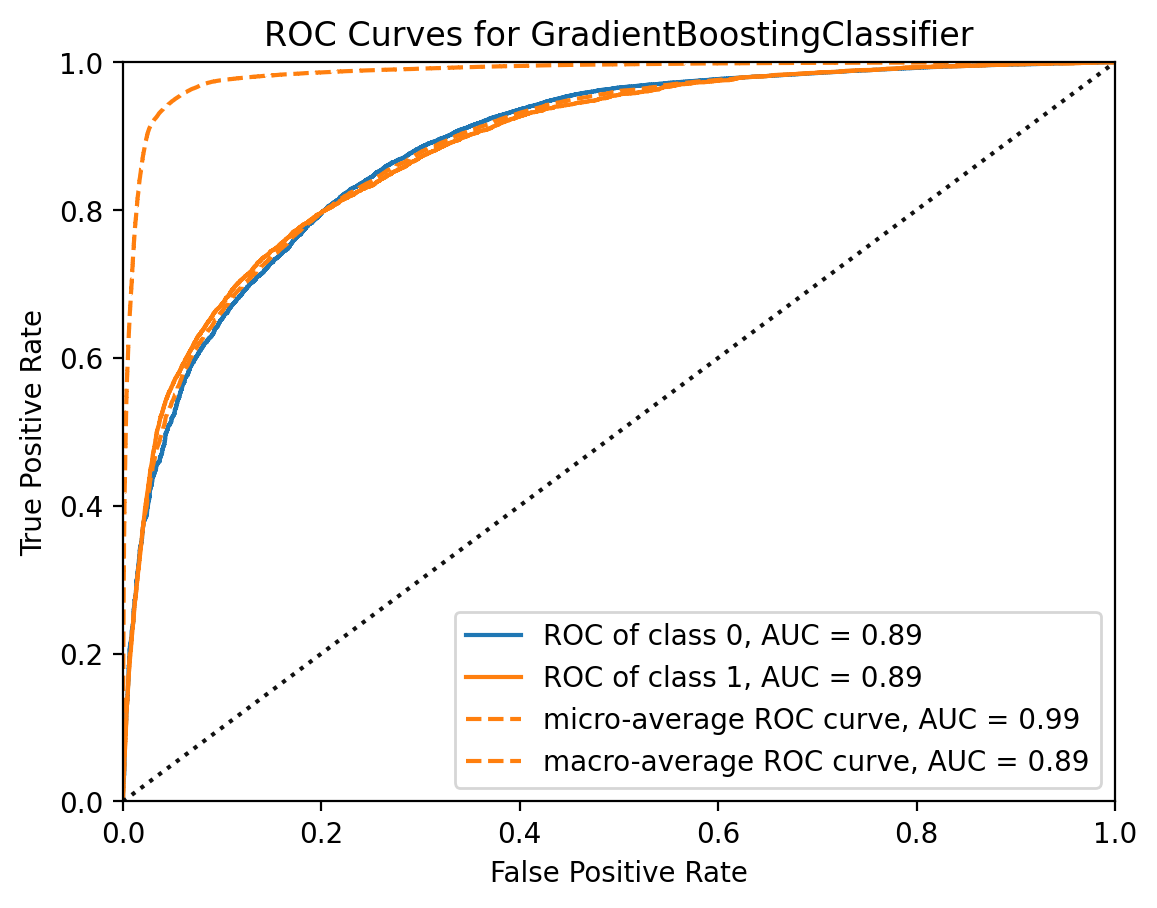

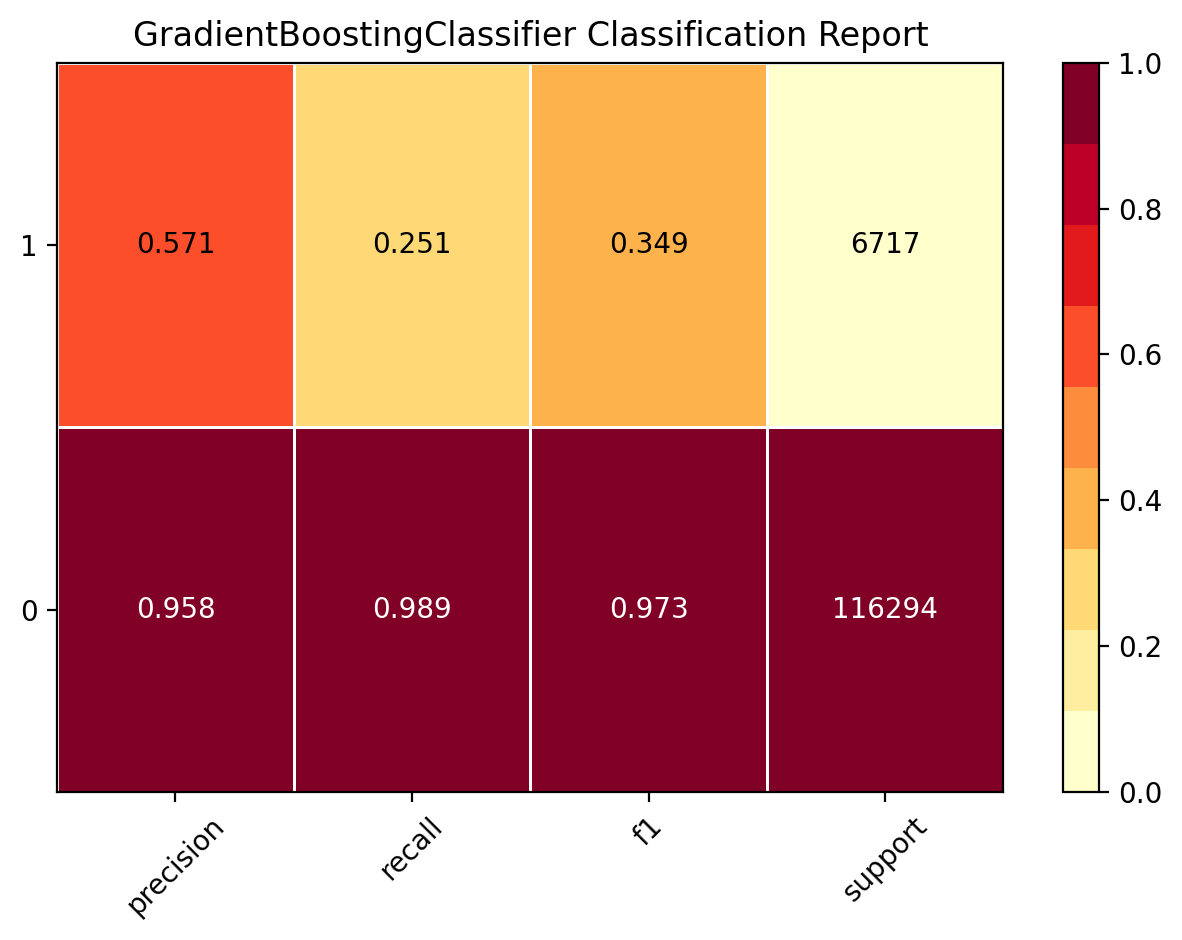

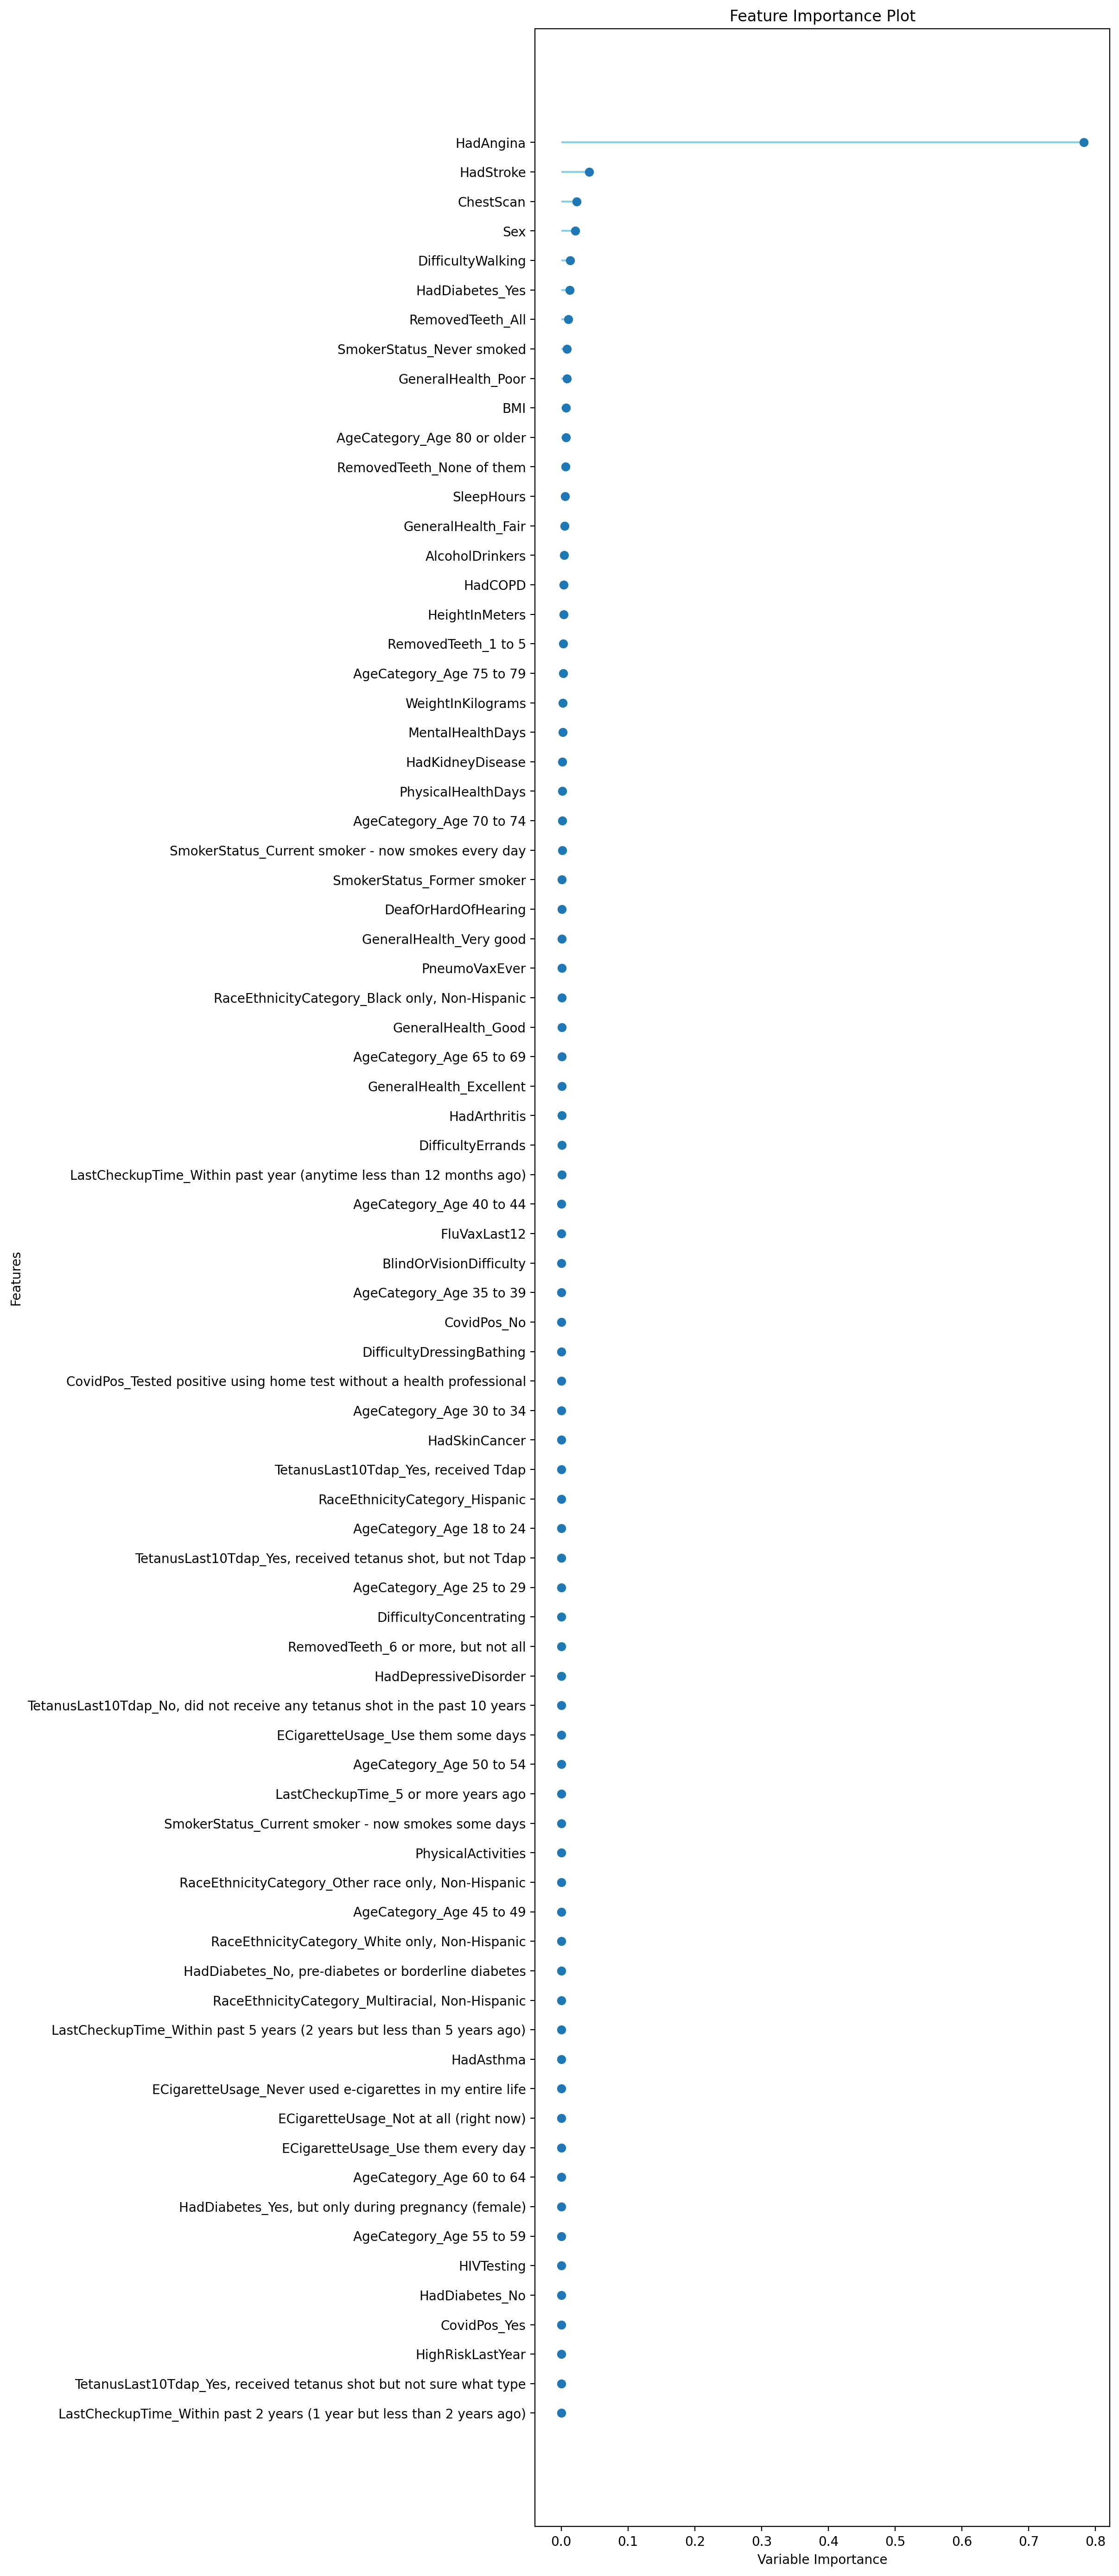

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.1
loss,log_loss
max_depth,3
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1


In [16]:
# profile the best model
# reset old global plot parameters
plt.rcdefaults()

plot_types = [
  'pipeline',
  'auc',
  'class_report',
  'feature_all',
  'parameter',
]
for plot_type in plot_types:
  exp.plot_model(
    estimator=best_model,
    plot=plot_type,
    plot_kwargs={
      'block': False,
    },
    scale=2,
  )

In [17]:
# tune the best model

tuned_best_model = exp.tune_model(
  estimator=best_model,
  optimize='auc',
  n_iter=10,
  search_library='optuna',
)
exp.plot_model(
  estimator=tuned_best_model,
  plot='parameter',
  plot_kwargs={
    'block': False,
  },
  scale=2,
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9454,0.8902,0.9454,0.8937,0.9188,0.0000,0.0000
1,0.9455,0.8786,0.9455,0.8939,0.9189,0.0000,0.0000
2,0.9455,0.8844,0.9455,0.8939,0.9189,0.0000,0.0000
3,0.9454,0.8854,0.9454,0.8937,0.9188,0.0000,0.0000
4,0.9454,0.8757,0.9454,0.8937,0.9188,0.0000,0.0000
5,0.9454,0.8806,0.9454,0.8937,0.9188,0.0000,0.0000
6,0.9454,0.8786,0.9454,0.8937,0.9188,0.0000,0.0000
7,0.9454,0.8795,0.9454,0.8937,0.9188,0.0000,0.0000
8,0.9454,0.8780,0.9454,0.8937,0.9188,0.0000,0.0000


[I 2023-12-16 19:38:11,362] Searching the best hyperparameters using 123011 samples...
[I 2023-12-16 20:10:59,622] Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.1
loss,log_loss
max_depth,3
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1


In [18]:
# show hold-out predictions
predictions = exp.predict_model(
  estimator=best_model,
  raw_score=True,
)
predictions[filter(
  lambda name: name.startswith('prediction_'),
  predictions.columns,
)].sample(
  n=15,
  random_state=123,
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9488,0.8853,0.9488,0.9369,0.9392,0.3262,0.3563


,prediction_label,prediction_score_No,prediction_score_Yes
137519,No,0.9882,0.0118
158421,No,0.9958,0.0042
41305,No,0.9673,0.0327
22939,No,0.9747,0.0253
70895,No,0.9908,0.0092
196004,No,0.9795,0.0205
163369,No,0.9850,0.0150
196692,No,0.9864,0.0136
88122,No,0.9902,0.0098
15877,No,0.9899,0.0101


In [19]:
# save the experiment and model
from pathlib import Path

Path('../models/heart-best').mkdir(
  parents=True,
  exist_ok=True,
)

exp.save_experiment(
  path_or_file='../models/heart-best/experiment.pkl',
)
exp.save_model(
  model=best_model,
  model_name='../models/heart-best/model',
  model_only=False,
)
None

Transformation Pipeline and Model Successfully Saved
